In [1]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL.Image
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

%matplotlib inline

2023-05-13 11:11:35.993281: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
tf.keras.backend.clear_session()

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

2023-05-13 11:11:37.348070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 11:11:37.355162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 11:11:37.355721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# read in the data
root_dir = r'./data/dino_dragon_images'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

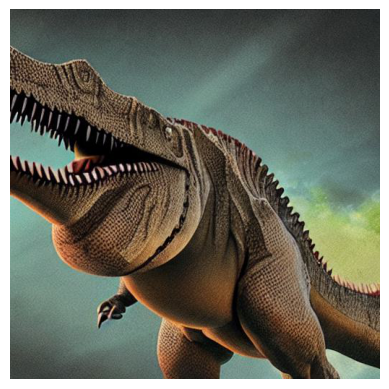

In [6]:
# view a dino image
dino_dir = os.path.join(train_dir, 'dino')
dino_image = os.listdir(dino_dir)[1]
img = PIL.Image.open(os.path.join(dino_dir, dino_image))
plt.imshow(img)
plt.axis("off");

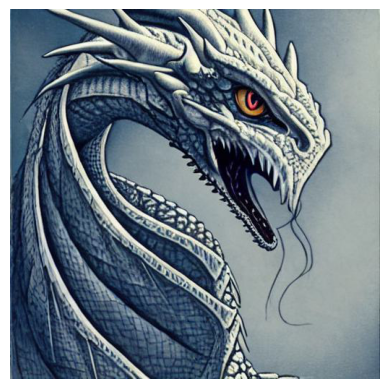

In [7]:
# and a dragon image
dragon_dir = os.path.join(train_dir, 'dragon')
dragon_image = os.listdir(dragon_dir)[1]
img = PIL.Image.open(os.path.join(dragon_dir, dragon_image))
plt.imshow(img)
plt.axis("off");

In [8]:
# check the shape
img_arr = np.array(img)
img_arr.shape

(512, 512, 3)

In [10]:
# define the model
inputs = keras.Input(shape=(150, 150, 3))
conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
pool = keras.layers.MaxPool2D()(conv)
flat = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(64, activation='relu')(flat)
outputs = keras.layers.Dense(1, activation='sigmoid')(dense)

model = keras.Model(inputs, outputs, name='dino-dragon-model')
model.summary()

# specify the optimiser and loss
optimiser = keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)
loss = 'binary_crossentropy'

Model: "dino-dragon-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                11214912  
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                 

In [11]:
# pull in the data
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_ds = val_gen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


In [12]:
# check the shapes
for data_batch, labels_batch in train_ds:
    print(data_batch.shape)
    print(labels_batch.shape)
    break

(20, 150, 150, 3)
(20,)


In [13]:
# compile the model
model.compile(
    optimizer=optimiser,
    loss=loss,
    metrics=['accuracy']
)

In [30]:
# fit the model
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
80/80 [==============================] - 9s 108ms/step - loss: 0.0914 - accuracy: 0.9699 - val_loss: 0.2467 - val_accuracy: 0.9036
Epoch 2/20
80/80 [==============================] - 8s 105ms/step - loss: 0.0556 - accuracy: 0.9893 - val_loss: 0.2418 - val_accuracy: 0.9112
Epoch 3/20
80/80 [==============================] - 8s 105ms/step - loss: 0.0434 - accuracy: 0.9956 - val_loss: 0.2428 - val_accuracy: 0.9036
Epoch 4/20
80/80 [==============================] - 8s 104ms/step - loss: 0.0328 - accuracy: 0.9981 - val_loss: 0.2922 - val_accuracy: 0.8959
Epoch 5/20
80/80 [==============================] - 8s 106ms/step - loss: 0.0300 - accuracy: 0.9987 - val_loss: 0.3042 - val_accuracy: 0.8832
Epoch 6/20
80/80 [==============================] - 8s 106ms/step - loss: 0.0259 - accuracy: 0.9981 - val_loss: 0.2629 - val_accuracy: 0.9086
Epoch 7/20
80/80 [==============================] - 8s 106ms/step - loss: 0.0220 - accuracy: 0.9987 - val_loss: 0.2702 - val_accuracy: 0.9061
Epoch 

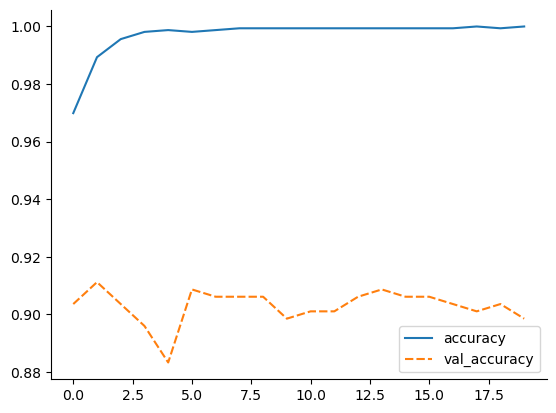

In [31]:
history_df = pd.DataFrame(history.history)
sns.lineplot(history_df[['accuracy', 'val_accuracy']])
sns.despine();

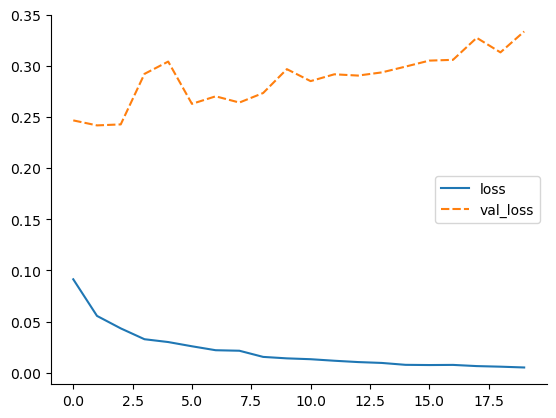

In [32]:
sns.lineplot(history_df[['loss', 'val_loss']])
sns.despine();

In [33]:
# 3. What is the median training accuracy?
print(np.median(history_df.accuracy))

0.999372661113739


In [34]:
# 4. What is the standard deviation training loss?
print(np.std(history_df.loss))

0.020692869906040995


In [35]:
# add augmentation to the training data generator
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_ds_aug = train_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 1594 images belonging to 2 classes.


In [36]:
# train the model for another 20 epochs
history = model.fit(train_ds_aug, epochs=20, validation_data=val_ds)

Epoch 1/20
80/80 [==============================] - 15s 190ms/step - loss: 0.3720 - accuracy: 0.8545 - val_loss: 0.3054 - val_accuracy: 0.8680
Epoch 2/20
80/80 [==============================] - 15s 189ms/step - loss: 0.3194 - accuracy: 0.8620 - val_loss: 0.3205 - val_accuracy: 0.8680
Epoch 3/20
80/80 [==============================] - 15s 187ms/step - loss: 0.3115 - accuracy: 0.8726 - val_loss: 0.3130 - val_accuracy: 0.8706
Epoch 4/20
80/80 [==============================] - 15s 188ms/step - loss: 0.3182 - accuracy: 0.8708 - val_loss: 0.3282 - val_accuracy: 0.8629
Epoch 5/20
80/80 [==============================] - 15s 187ms/step - loss: 0.3099 - accuracy: 0.8770 - val_loss: 0.5467 - val_accuracy: 0.7944
Epoch 6/20
80/80 [==============================] - 15s 190ms/step - loss: 0.3187 - accuracy: 0.8695 - val_loss: 0.2371 - val_accuracy: 0.8934
Epoch 7/20
80/80 [==============================] - 15s 188ms/step - loss: 0.2966 - accuracy: 0.8745 - val_loss: 0.2712 - val_accuracy: 0.8807

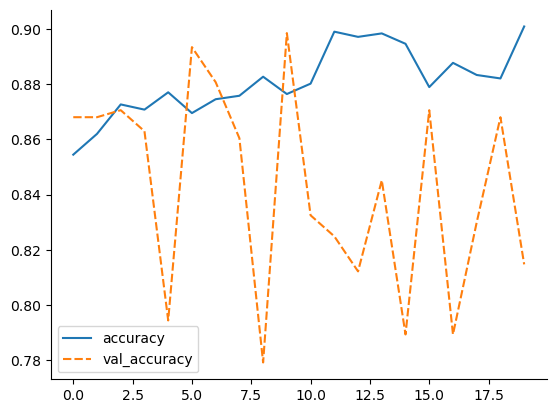

In [37]:
history_df = pd.DataFrame(history.history)
sns.lineplot(history_df[['accuracy', 'val_accuracy']])
sns.despine();

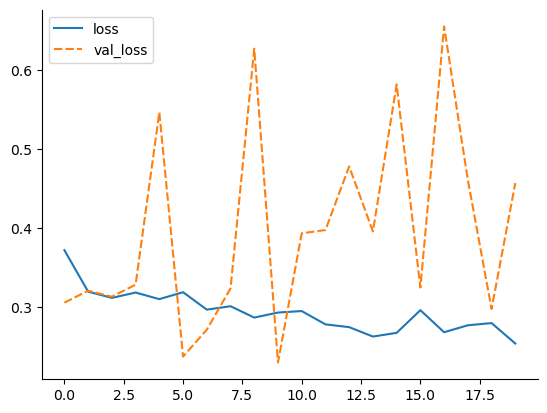

In [38]:
sns.lineplot(history_df[['loss', 'val_loss']])
sns.despine();

In [39]:
# 5. What is the mean validation loss?
print(np.mean(history_df.val_loss))

0.3972176782786846


In [40]:
# 6. What is the mean validation accuracy?
print(np.mean(history_df.loc[5:10, 'val_accuracy']))

0.8574450016021729
